# Morphological layer

Przydatne funkcje (M.I. 14.12.2020)

In [17]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
import skimage.morphology as smo
import time

# zmiana sposobu wyświetlania danych typu float
pd.options.display.float_format = "{:.2f}".format 

Przydatne do wyświetlania

In [3]:
def imshow_cv2(obraz, tytul = '', osie = False, opencv = True):
    # universal image display function via plt
    # ** M.I. 9.12.20
    if not(osie):
        plt.axis("off") 
    if obraz.ndim == 2:
        plt.imshow(obraz,cmap='gray')
    else:
        if opencv:
            plt.imshow(cv2.cvtColor(obraz,cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(obraz)
    plt.title(tytul)

def imlish(listaobr, ile_k = 1, listatyt = [], opencv = True, wart_dpi = 100, osie = False):
    # shows listed images
    # listaobr - list of images
    # ile_k - number of columns
    # listatyt - list of image captions
    # opencv = True - treat color images with openCV-like order of components
    # wart_dpi - resolution
    # osie = False - axes off
    rozm_obr = 5
    ile = len(listaobr)
    if len(listatyt) == 0:
        listatyt = [' ']*ile
    ile_w = np.ceil(ile / ile_k).astype(int)
    figsize_k = rozm_obr*ile_k
    figsize_w = rozm_obr*ile_w
    plt.figure(figsize=(figsize_k,figsize_w), dpi = wart_dpi)
    for i in range(0,ile):
        if isinstance(listaobr[i],np.ndarray):
            plt.subplot(ile_w,ile_k,i+1)
            imshow_cv2(listaobr[i],listatyt[i],osie,opencv)
    plt.show()
    

Dodaje ramkę do obrazu

In [4]:
def imaddborder(im,x,y,val,rel = False):
    # Adds a border to the input image
    # rel = True - x,y - size of the added border
    # rel = False - x,y - size of the image with added border
    # val - pixel value 
    # ** M.I. 9.12.20
    (sx_org,sy_org) = im.shape
    if rel:
        sx = sx_org + 2*x
        sy = sy_org + 2*y
    else:
        sx = x
        sy = y
    img = np.ones([sx,sy])*val
    [cx, cy] = ((np.array([sx,sy])-np.array([sx_org,sy_org]))/2).astype('int')
    img[cx:(cx+sx_org),cy:(cy+sy_org)] = im
    return img

Tworzy sekwencję elementów strukturujących i zapisuje ją jako listę

In [5]:
def getselist(n,type = 'disk', initsize = 1, step = 1):
    # generate a list of n structuring elements
    # type = 'disk', 'square', 'disk'
    # ** M.I. 9.12.20
    selist = []
    sesize = initsize
    for i in range(n):
        if (type == 'disk'):
            se = smo.disk(sesize)
        elif (type == 'square'):
            se = smo.square(2*sesize + 2)
        else: # (type == 'diamond'):
            se = smo.diamond(sesize)       
        selist.append(se)
        sesize += step
    return selist

Tak wygląda ta sekwencja

In [7]:
getselist(3, type = 'diamond', initsize = 2, step=2)

[array([[0, 0, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1

Generuje stos obrazów (macierz 3D numpy) składającą się z ciągu operacji rosnących (incresaing: dylacje/otwarcia) i majelących (decreasing: erozje/zamknięcia). Można użyć funkcji Scikit image (2 warianty) i openCV (szybsze !).

In [8]:
def morphostack(imin, maxsizes, optype = 'cv_oc', setype = 'disk', seinitsize = 1, sestep = 1,  addborder = True):
    # produce a stack of results of the morphological dual operators
    # imin - imput image (binary or graylevel 2D image)
    # maxsizes - list of two values - numers of up-stack and down-stack images
    # optype - type of operations erosion/dilation <-> opening/closing; skimage binary <-> skimage graytone <-> opencv
    # setype = structuring element type ('disk', 'square', 'diamond')
    # seinitsize = initial size of the structuring element 
    # sestep = increment of the structuring element size
    # addborder = True if the external boundary is added, = False otherwise
    # ** M.I. 9.12.20
    maxup = maxsizes[0] # number of up-stack images (higher indeces, dilation/opening)
    maxdn = maxsizes[1] # number of down-stack images (kower indeces, erosion/closing)
    maxud = max(maxup,maxdn)
    selist = getselist(maxud,type = setype, initsize = seinitsize, step = sestep)
    if addborder:
        im = imaddborder(imin,maxud,maxud,0,True)
    else:
        im = imin
    imout = np.zeros([im.shape[0],im.shape[1],maxup + maxdn + 1])    
    count = 0
    opencv = False
    if optype == 'b_ed': # binary erosion/dilation - scikit.image
        operator_down = smo.binary_erosion
        operator_up = smo.binary_dilation
    elif optype == 'b_oc': # binary opening/closing - scikit.image
        operator_down = smo.binary_opening
        operator_up = smo.binary_closing      
    elif optype == 'ed': # erosion/dilation - scikit.image     
        operator_down = smo.erosion
        operator_up = smo.dilation
    elif optype == 'oc': # opening/closing - scikit.image
        operator_down = smo.opening
        operator_up = smo.closing      
    elif optype == 'cv_ed': # erosion/dilation - openCV 
        opencv = True
        operator_down = cv2.MORPH_ERODE
        operator_up = cv2.MORPH_DILATE
    else: # optype == 'cv_oc': # opening/closing - openCV 
        opencv = True
        operator_down = cv2.MORPH_OPEN
        operator_up = cv2.MORPH_CLOSE     
    if opencv:  # opencv version 
        for i in range(maxdn):
            imout[:,:,count] = cv2.morphologyEx(im, operator_down, selist[maxdn-i-1]); count += 1
        imout[:,:,count] = im; count += 1
        for i in range(maxup):
            imout[:,:,count] = cv2.morphologyEx(im, operator_up, selist[i]); count += 1
    else:   # scikit image version
        for i in range(maxdn):
            operator_down(im, selem = selist[maxdn-i-1], out = imout[:,:,count]); count += 1
        imout[:,:,count] = im; count += 1
        for i in range(maxup):
            operator_up(im, selem = selist[i], out = imout[:,:,count]); count += 1       
    return imout

Porównanie czasu wykonywania operacji morfologicznych openCV, Scikit image binary i Scikit image. Różnica na korzyść openCV jest b. znacząca !

openCV - czas:1.141


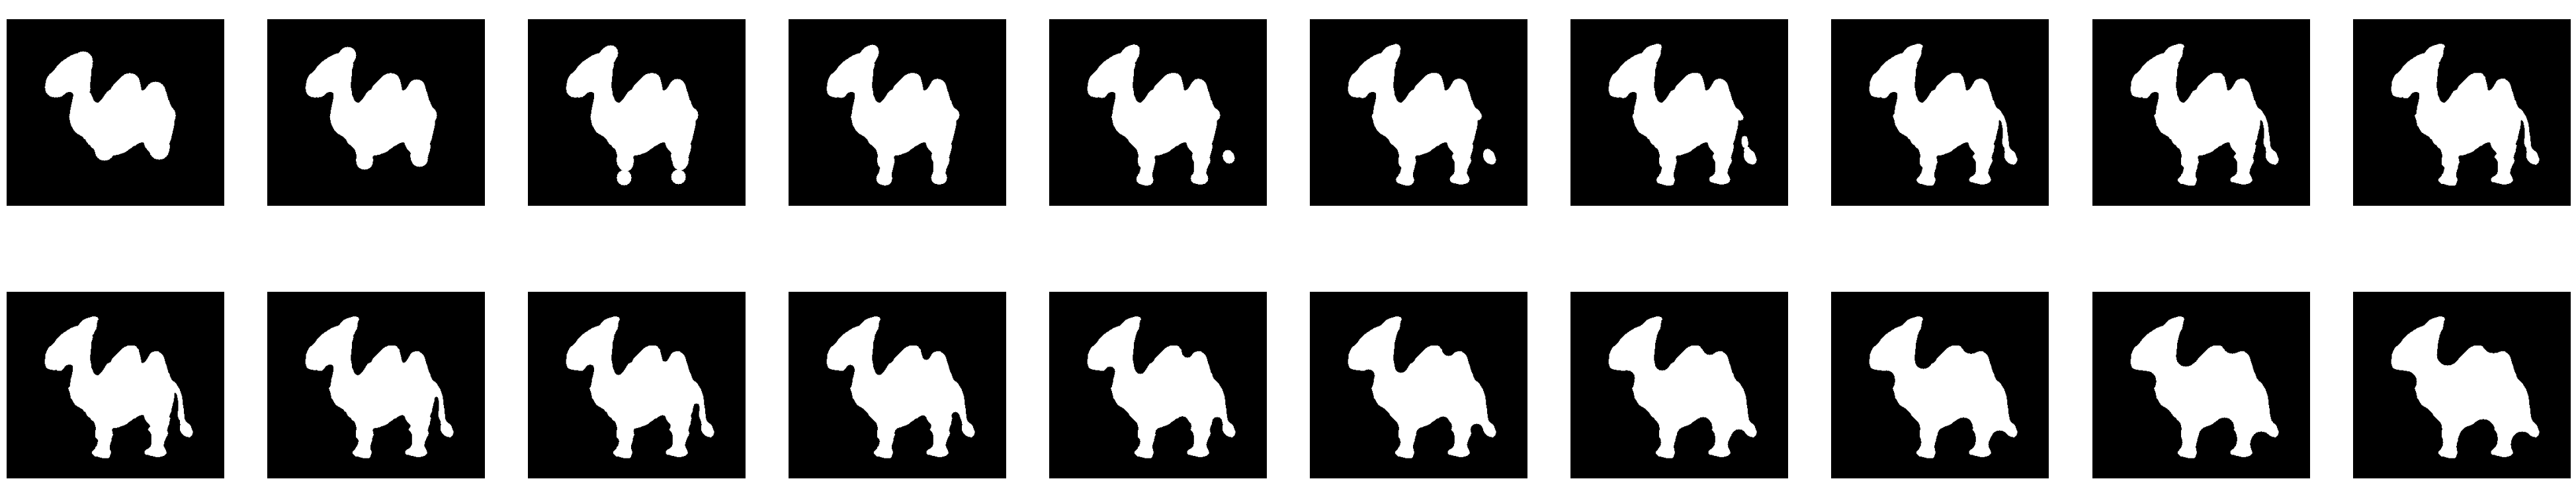

scikit image binary - czas:0.762


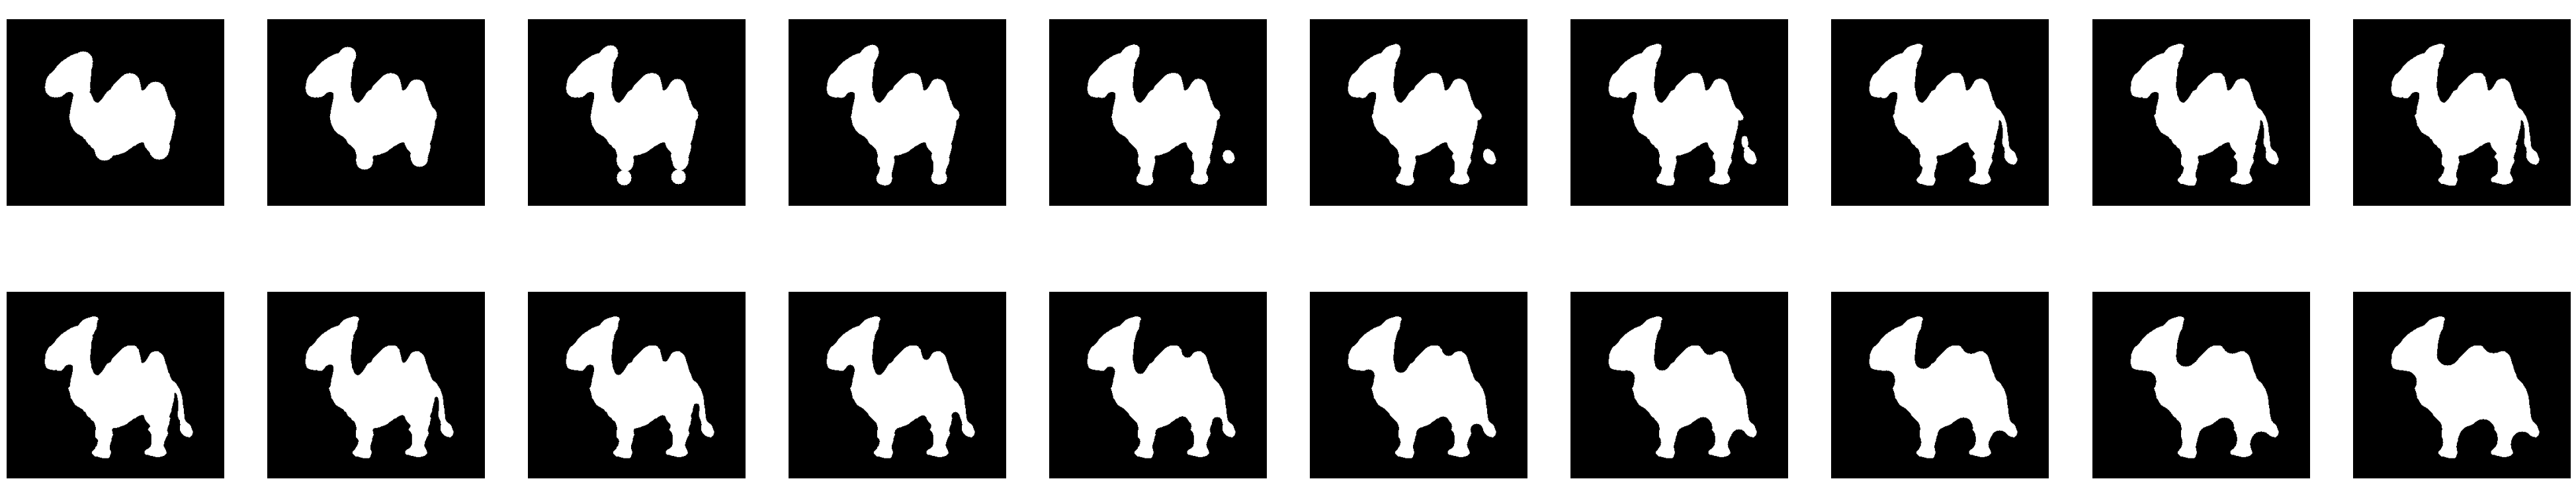

scikit image - czas:2.44


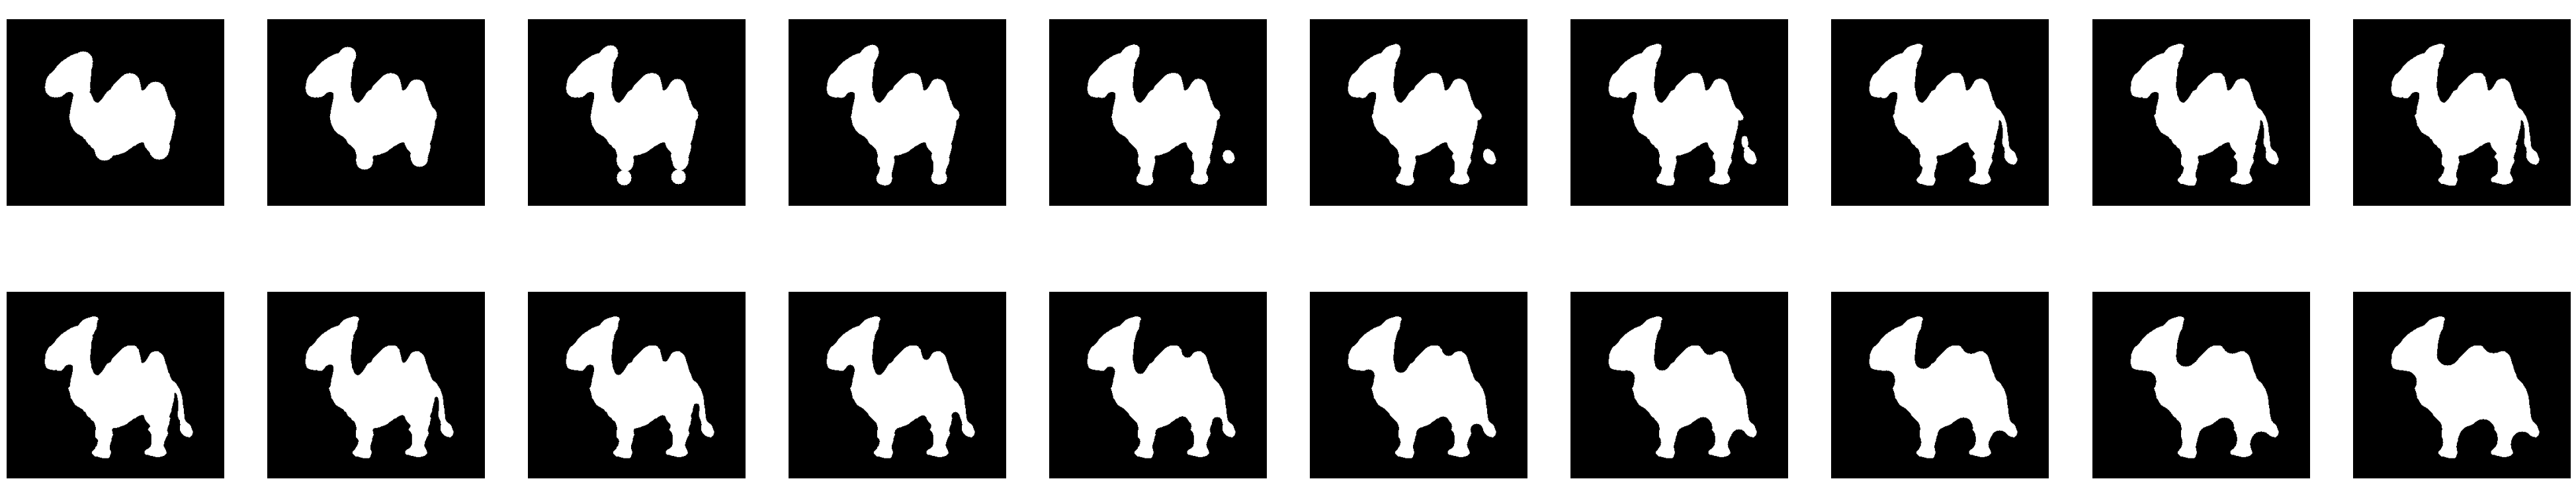

In [9]:
obraz = imread("camel-19.gif")
#obraz = imread("kalkulator.png")
if len(obraz.shape) == 3:
    obraz = obraz[:,:,1]
#    
sizes = [10,9]
# wariant openCV    
t = time.time()
imout = morphostack(obraz,sizes,'cv_oc','disk',sestep = 2)
print('openCV - czas:' + str(np.round_(time.time() - t, 3)))
listaob = [] 
for i in range(imout.shape[2]):
    listaob.append(imout[:,:,i])
imlish(listaob,10)    

# wariant scikit image binary
t = time.time()
imout = morphostack(obraz,sizes,'b_oc','disk',sestep = 2)
print('scikit image binary - czas:' + str(np.round_(time.time() - t, 3)))
listaob = [] 
for i in range(imout.shape[2]):
    listaob.append(imout[:,:,i])    
imlish(listaob,10)

# wariant scikit image
t = time.time()
imout = morphostack(obraz,sizes,'oc','disk',sestep = 2)
print('scikit image - czas:' + str(np.round_(time.time() - t, 3)))
listaob = [] 
for i in range(imout.shape[2]):
    listaob.append(imout[:,:,i])    
imlish(listaob,10)

"Spłaszczenie" stosu obrazów (binarnych) w jeden obraz w skali szarości. Użycie normalizacji daje wynik w postaci unormowanej tj. wartości pikseli między -1 a 1.

In [46]:
def flatmostack(imin, maxsizes, normalize = True):
    maxud = maxsizes[0] + maxsizes[1] + 1
    maxval = imin.max()
    imout = np.sum(imin/maxval,axis=2)
    if normalize:
        imout /= maxud
    return imout

In [16]:
imout[2].shape

(388, 20)

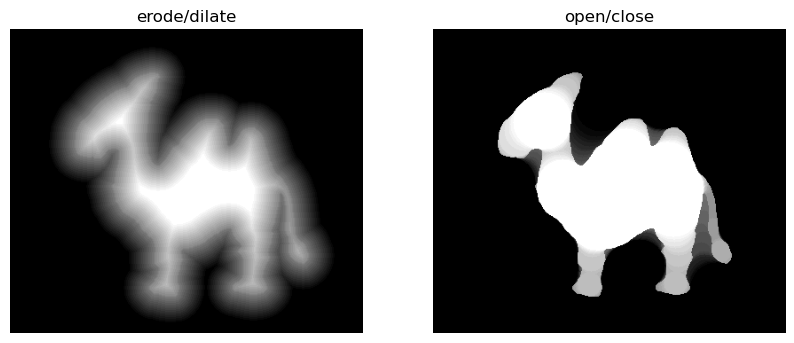

In [50]:
sizes = [15,15]
imout = morphostack(obraz,sizes,'cv_ed','disk',sestep = 2)
flat1 = flatmostack(imout,sizes)
imout = morphostack(obraz,sizes,'cv_oc','disk',sestep = 2)
flat2 = flatmostack(imout,sizes)
imlish([flat1,flat2],2,['erode/dilate','open/close'])